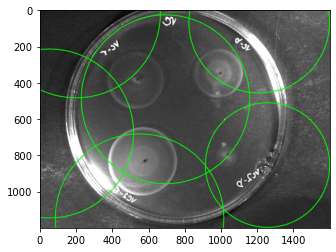

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread('1.jpg')
output = image.copy()
height, width = image.shape[:2]
maxRadius = int(7*(width/12)/2)
minRadius = int(5*(width/12)/2)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
circles = cv2.HoughCircles(image=gray, 
                           method=cv2.HOUGH_GRADIENT, 
                           dp=1.1, 
                           minDist=2*minRadius,
                           param1=30,
                           param2=30,
                           minRadius=minRadius,
                           maxRadius=maxRadius                           
                          )

if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circlesRound = np.round(circles[0, :]).astype("int")
    # loop over the (x, y) coordinates and radius of the circles
    for (x, y, r) in circlesRound:
        cv2.circle(output, (x, y), r, (0, 255, 0), 4)

    plt.imshow(output)
else:
    print ('No circles found')

In [ ]:
import numpy as np
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

# Load in image, convert to gray scale, and Otsu's threshold
image = cv2.imread('1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Remove small noise by filtering using contour area
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    if cv2.contourArea(c) < 500:
        cv2.drawContours(thresh,[c], 0, (0,0,0), -1)

cv2.imshow('thresh', thresh)
# Compute Euclidean distance from every binary pixel
# to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    cv2.drawContours(image, [c], -1, (36,255,12), -1)

cv2.imshow('image', image)
cv2.waitKey()